
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"].groupby(["Pos"]).mean()["Total Points"]

In [5]:
df.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Att.1', 'Succ',
       'Match Report', 'Name', 'Season', 'Fls', 'Fld', 'Off', 'Crs', 'TklW',
       'OG', 'PKwon', 'PKcon', 'WDL', 'GoalsTeams', 'Team Score', 'Opp Score',
       'CS', 'Was Home', 'GW', 'neutral_name', 'Total Points', 'FPL position',
       'Opp rating', 'Team rating', 'ScoreForLast5', 'ScoreAgainstLast5',
       'Min_points', 'MinAvgOverall', 'GlsAvgOverall', 'AstAvgOverall',
       'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall', 'xAGAvgOverall',
       'CSAvgOverall', 'Team ScoreAvgOverall', 'Opp ScoreAvgOverall'],
      dtype='object')

# Preparing dataset

In [6]:
# features = ["Was Home", "Team rating", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5', 
#         'MinAvgOverall', 'GlsAvgOverall',
#        'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
#        'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
#        'Opp ScoreAvgOverall']

In [7]:
def calculate_xg_points(row):
    if row["FPL position"] == "GK":
        return row["xG"] * 6
    elif row["FPL position"] == "DEF":
        return row["xG"] * 6
    elif row["FPL position"] == "MID":
        return row["xG"] * 5
    elif row["FPL position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [8]:
def calculate_cs_points(row):
    if row["FPL position"] == "GK":
        return row["xG"] * 4
    elif row["FPL position"] == "DEF":
        return row["xG"] * 4
    elif row["FPL position"] == "MID":
        return row["xG"] * 1
    elif row["FPL position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [9]:
to_predict = ["Total Points"]
features1 = ["Was Home", "Team rating", "Opp rating", 
             # 'ScoreForLast5', 'ScoreAgainstLast5',
             ]
features_to_roll = [
                "Min", "Start",
                'Gls', 'Ast', 'Sh',
                'SoT', 'CrdY', 'CrdR', 'xAG', 
                # 'CS', "xG",
                'Team Score', 'Opp Score',
                "xGPoints", "CSPoints",
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                "Total Points"
            ]
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "FPL position"]

In [10]:
def add_rolling_features(df, features1, features_to_roll):
    rolling_gameweeks = [2,5]
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().reset_index()
        form_means = form_means.shift(1)
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [11]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)
        # df = df.drop(c, axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [12]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 2,
        'Y*': 1,
        'N': 0,
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [13]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [14]:
df, features = ohe(df, ["FPL position"], features)

In [15]:
df = label_encoding(df, "Start")

In [16]:
df = df[np.unique(features + info + to_predict)]

In [17]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [18]:
# dropping NaNs
df = df.dropna(axis=0)

In [19]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [20]:
df.columns

Index(['Ast_2', 'Ast_5', 'CSPoints_2', 'CSPoints_5', 'CrdR_2', 'CrdR_5',
       'CrdY_2', 'CrdY_5', 'DEF', 'FPL position', 'FWD', 'GK', 'GW', 'Gls_2',
       'Gls_5', 'MID', 'Min_2', 'Min_5', 'Name', 'Opp Score_2', 'Opp Score_5',
       'Opp rating', 'Opponent', 'Season', 'Sh_2', 'Sh_5', 'SoT_2', 'SoT_5',
       'Squad', 'Team Score_2', 'Team Score_5', 'Team rating', 'Total Points',
       'Total Points_2', 'Total Points_5', 'Was Home', 'level_1_2',
       'level_1_5', 'xAG_2', 'xAG_5', 'xGPoints_2', 'xGPoints_5'],
      dtype='object')

# Choosing features and splitting data

In [21]:
GAMEWEEK_TO_PREDICT = 31
SEASON_TO_PREDICT = "2022-23"

In [22]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [23]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [24]:
X_train.shape, X_test.shape

((17390, 35), (366, 35))

# Model

In [25]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [26]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [27]:
# model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [28]:
%%time
model.fit(X_train, np.array(y_train).ravel())

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3194
[LightGBM] [Info] Number of data points in the train set: 17390, number of used features: 35
[LightGBM] [Info] Start training from score 2.285911
CPU times: total: 9.3 s
Wall time: 5.39 s


# Evaluation

In [29]:
# make predictions on the test data
predictions = model.predict(X_test)

In [30]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [31]:
df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
df_predictions.loc[:, "pred"] = predictions

In [32]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["Total Points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [33]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    # print(preds)
    # print(y)
    
    return  pairwise_accuracy(preds, y)

In [34]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [35]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

pairwise_acc = pairwise_accuracy(np.array(y_test), predictions)
pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)

In [36]:
print("MAE:", mae)
print("MSE:", mse)
print("Pairwise accuracy:", pairwise_acc)
print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

MAE: 1.7579786600320955
MSE: 7.346059527568177
Pairwise accuracy: 0.5818100157197394
Pairwise accuracy @TOP100: 0.4898119122257053
Pairwise accuracy @TOP20: 0.5751633986928104


In [37]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [38]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [39]:
preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)

In [40]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
110,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,6.536827
147,Jack-Grealish,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,7.0,6.298222
130,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.138883
282,Ollie-Watkins,31,2022-23,Aston Villa,Newcastle Utd,1.0,1804.471680,1879.303101,FWD,16.0,5.745220
197,Julian-Alvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,5.482080
271,Nathan-Ake,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,5.431417
146,Ivan-Toney,31,2022-23,Brentford,Wolves,0.0,1785.234741,1720.871338,FWD,2.0,5.009084
206,Kevin-De-Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,4.936688
141,Ilkay-Gundogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,0.0,4.924004
315,Ruben-Dias,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,2.0,4.874254


In [41]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
110,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,6.536827
147,Jack-Grealish,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,7.0,6.298222
197,Julian-Alvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,5.482080
271,Nathan-Ake,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,0.0,5.431417
206,Kevin-De-Bruyne,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,8.0,4.936688
141,Ilkay-Gundogan,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,0.0,4.924004
315,Ruben-Dias,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,DEF,2.0,4.874254
99,Ederson,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,GK,3.0,4.852092
35,Bernardo-Silva,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,1.0,4.808927
305,Riyad-Mahrez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,MID,2.0,4.798017


In [42]:
preds[preds["FPL position"] == "FWD"].head(10)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
110,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,6.536827
130,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.138883
282,Ollie-Watkins,31,2022-23,Aston Villa,Newcastle Utd,1.0,1804.471680,1879.303101,FWD,16.0,5.745220
197,Julian-Alvarez,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,1.0,5.482080
146,Ivan-Toney,31,2022-23,Brentford,Wolves,0.0,1785.234741,1720.871338,FWD,2.0,5.009084
98,Eddie-Nketiah,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,FWD,1.0,3.941625
11,Alexander-Isak,31,2022-23,Newcastle Utd,Aston Villa,0.0,1879.303101,1804.471680,FWD,2.0,3.904678
93,Dominic-Solanke,31,2022-23,Bournemouth,Tottenham,0.0,1668.258545,1854.798462,FWD,15.0,3.797433
123,Gabriel-Jesus,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,FWD,7.0,3.560789
40,Brennan-Johnson,31,2022-23,Nott'ham Forest,Manchester Utd,1.0,1638.596069,1882.111816,FWD,2.0,3.393985


# Feature importance and influence

In [43]:
# plot_importance(model)

In [44]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [45]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 367it [04:57,  1.19it/s]                                                                                                                                    


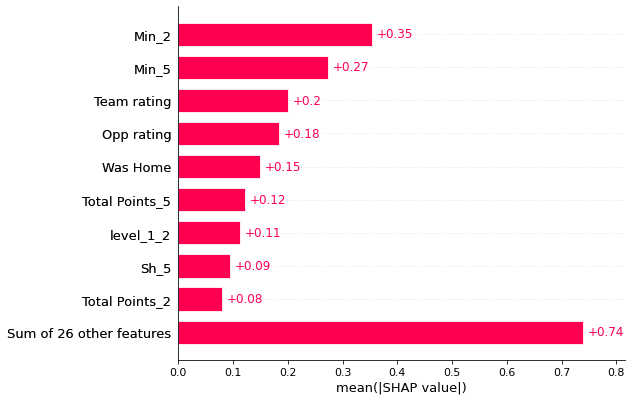

In [46]:
shap.plots.bar(shap_values)

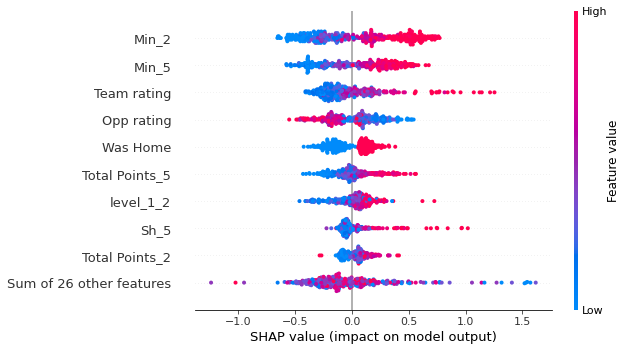

In [47]:
shap.plots.beeswarm(shap_values)

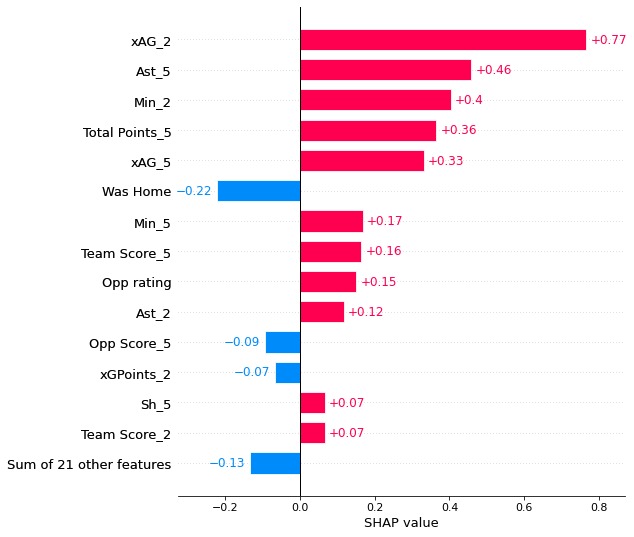

In [48]:
shap.plots.bar(shap_values[218], max_display=15)

In [49]:
# get_top_performer_names(df, 20, 50)

In [50]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 50, 50)))]